# Kaggle Playground Series S-5 ep-4

### Dependencies

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split

In [2]:
sns.set_theme(style = "darkgrid")
warnings.filterwarnings("ignore")

### Preparing the Dataframe

In [28]:
train_df = pd.read_csv(os.path.join("Data","train.csv"))
train_df.set_index(train_df["id"],inplace=True)
train_df.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,,,,,,
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [29]:
print(train_df.isna().sum())
train_df["Episode_Length_minutes"].fillna(train_df["Episode_Length_minutes"].mean(),inplace=True)
train_df["Guest_Popularity_percentage"].fillna(train_df["Guest_Popularity_percentage"].mean(),inplace=True)
train_df["Number_of_Ads"].fillna(0,inplace=True)
print("==============================================")
print(train_df.isna().sum())

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64
id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
dtype: int64


In [31]:
sameple_df = train_df.sample(n = 5000)
sameple_df.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,,,,,,
497520,497520,Lifestyle Lounge,Episode 71,93.400000,Lifestyle,21.55,Saturday,Morning,87.890000,2.0,Neutral,57.22519
200270,200270,Crime Chronicles,Episode 67,7.150000,True Crime,88.09,Saturday,Morning,31.250000,1.0,Negative,0.00000
393150,393150,Learning Lab,Episode 53,103.400000,Education,69.40,Monday,Morning,46.720000,3.0,Neutral,41.86271
738449,738449,Fashion Forward,Episode 91,64.504738,Lifestyle,98.22,Saturday,Morning,61.310000,2.0,Neutral,68.87280
399084,399084,Crime Chronicles,Episode 22,10.710000,True Crime,29.67,Thursday,Morning,52.236449,2.0,Positive,7.45494


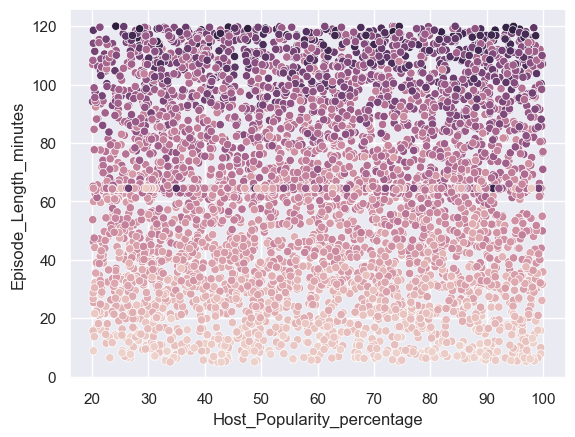

In [32]:
sns.scatterplot(data=sameple_df,x = "Host_Popularity_percentage",y = "Episode_Length_minutes",hue = "Listening_Time_minutes",legend=False)
plt.show()

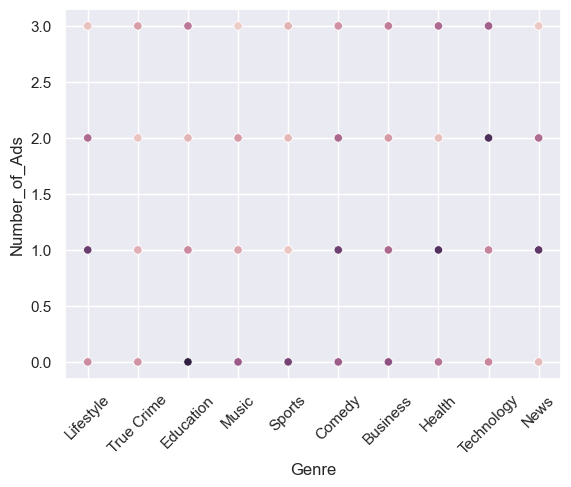

In [33]:
sns.scatterplot(data=sameple_df,x = "Genre",y = "Number_of_Ads",hue = "Listening_Time_minutes",legend=False)
plt.xticks(rotation = 45)
plt.show()

### Preprocessing

In [34]:
genre_columns = train_df["Genre"].unique()
ep_sentiment_columns = train_df["Episode_Sentiment"].unique()


print(f"Genre Columns: {genre_columns}")
print("=======================================")
print(f"Episode Sentiment Columns: {ep_sentiment_columns}")

Genre Columns: ['True Crime' 'Comedy' 'Education' 'Technology' 'Health' 'News' 'Music'
 'Sports' 'Business' 'Lifestyle']
Episode Sentiment Columns: ['Positive' 'Negative' 'Neutral']


In [35]:
def Preprocessing(df):
    df.drop(columns = ["id","Episode_Title","Publication_Day","Publication_Time","Podcast_Name"],inplace=True)
    genre_df = pd.get_dummies(df["Genre"],prefix="Genre_",dtype="float")
    ep_sentiment_df = pd.get_dummies(df["Episode_Sentiment"],prefix="Episode_Sentiment_",dtype="int")

    df = pd.concat([df,genre_df],axis = 1)
    df = pd.concat([df,ep_sentiment_df],axis = 1)

    df.drop(columns = ["Genre","Episode_Sentiment"],inplace=True)
    return df

In [37]:
preprocessed_df = Preprocessing(train_df)
preprocessed_df.head()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes,Genre__Business,Genre__Comedy,Genre__Education,Genre__Health,Genre__Lifestyle,Genre__Music,Genre__News,Genre__Sports,Genre__Technology,Genre__True Crime,Episode_Sentiment__Negative,Episode_Sentiment__Neutral,Episode_Sentiment__Positive
id,,,,,,,,,,,,,,,,,,
0,64.504738,74.81,52.236449,0.0,31.41998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1
1,119.800000,66.95,75.950000,2.0,88.01241,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
2,73.900000,69.97,8.970000,0.0,44.92531,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
3,67.170000,57.22,78.700000,2.0,46.27824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1
4,110.510000,80.07,58.680000,3.0,75.61031,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


### Splitting the Data

In [ ]:
X = preprocessed_df.drop(columns = ["Listening_Time_minutes"]).values
y = preprocessed_df["Listening_Time_minutes"].values

In [13]:
y = y.astype("float")

In [14]:
print("X type:", type(X))
print("X dtype:", X.dtype)
print("First row of X:", X[0])

X type: <class 'numpy.ndarray'>
X dtype: float64
First row of X: [64.50473835 74.81       52.23644893  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          1.        ]


In [15]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=69)
print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (600000, 17)
y_train Shape: (600000,)
X_test Shape: (150000, 17)
y_test Shape: (150000,)


### Building the Model

In [94]:
reg = xgb.XGBRegressor(n_estimators = 5000,
                       max_depth = 5,
                       learning_rate = 0.1,
                       objective = "reg:squarederror",
                       verbose = 3,eval_metric = "rmse",booster = "gbtree")

In [95]:
eval_set = [(X, y)]

In [96]:
reg.fit(X,y,eval_set=eval_set)

[0]	validation_0-rmse:25.11141
[1]	validation_0-rmse:23.33945
[2]	validation_0-rmse:21.79798
[3]	validation_0-rmse:20.46174
[4]	validation_0-rmse:19.30962
[5]	validation_0-rmse:18.32237
[6]	validation_0-rmse:17.47966
[7]	validation_0-rmse:16.76491
[8]	validation_0-rmse:16.15876
[9]	validation_0-rmse:15.64960
[10]	validation_0-rmse:15.22464
[11]	validation_0-rmse:14.87095
[12]	validation_0-rmse:14.57549
[13]	validation_0-rmse:14.33124
[14]	validation_0-rmse:14.12968
[15]	validation_0-rmse:13.96211
[16]	validation_0-rmse:13.82399
[17]	validation_0-rmse:13.71012
[18]	validation_0-rmse:13.61643
[19]	validation_0-rmse:13.53938
[20]	validation_0-rmse:13.47675
[21]	validation_0-rmse:13.42460
[22]	validation_0-rmse:13.38166
[23]	validation_0-rmse:13.34644
[24]	validation_0-rmse:13.31696
[25]	validation_0-rmse:13.29275
[26]	validation_0-rmse:13.27308
[27]	validation_0-rmse:13.25643
[28]	validation_0-rmse:13.24203
[29]	validation_0-rmse:13.23031
[30]	validation_0-rmse:13.22036
[31]	validation_0-

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

ValueError: x and y must have same first dimension, but have shapes (10000,) and (1000,)

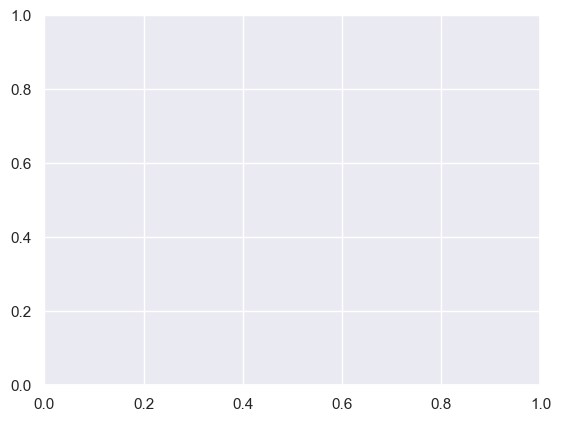

In [73]:
eval_res = reg.evals_result_
x_axis = range(0, 10000)
plt.plot(x_axis, eval_res['validation_0']["rmse"], label='Train')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('XGBoost Training and Test RMSE')
plt.show()

In [146]:
mean_y = y.mean()
std_y = y.std()
print(f"Mean of Target: {mean_y}")
print(f"Standard Deviation of Target: {std_y}")


Mean of Target: 45.43740628813335
Standard Deviation of Target: 27.138287735761345


In [97]:
reg = reg.save_model("v-4.bin")

In [89]:
test_df = pd.read_csv("Data/test.csv")
test_df.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


In [90]:
test_df = pd.read_csv("Data/test.csv")
test_df.set_index(test_df["id"],inplace=True)
test_df = Preprocessing(test_df)
test_df.head()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Genre__Business,Genre__Comedy,Genre__Education,Genre__Health,Genre__Lifestyle,Genre__Music,Genre__News,Genre__Sports,Genre__Technology,Genre__True Crime,Episode_Sentiment__Negative,Episode_Sentiment__Neutral,Episode_Sentiment__Positive
id,,,,,,,,,,,,,,,,,
750000,78.96,38.11,53.33,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
750001,27.87,71.29,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0
750002,69.10,67.89,97.51,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
750003,115.39,23.40,51.75,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
750004,72.32,58.10,11.30,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0


In [91]:
print(test_df.isnull().sum())

test_df["Episode_Length_minutes"].fillna(test_df["Episode_Length_minutes"].mean(),inplace=True)
test_df["Guest_Popularity_percentage"].fillna(test_df["Guest_Popularity_percentage"].mean(),inplace=True)

print("==================================")
print(test_df.isnull().sum())

Episode_Length_minutes         28736
Host_Popularity_percentage         0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Genre__Business                    0
Genre__Comedy                      0
Genre__Education                   0
Genre__Health                      0
Genre__Lifestyle                   0
Genre__Music                       0
Genre__News                        0
Genre__Sports                      0
Genre__Technology                  0
Genre__True Crime                  0
Episode_Sentiment__Negative        0
Episode_Sentiment__Neutral         0
Episode_Sentiment__Positive        0
dtype: int64
Episode_Length_minutes         0
Host_Popularity_percentage     0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Genre__Business                0
Genre__Comedy                  0
Genre__Education               0
Genre__Health                  0
Genre__Lifestyle               0
Genre__Music                   0
Genre__News                 

In [98]:
model = xgb.XGBRegressor()
model.load_model("v-4.bin")
model

XGBRegressor(base_score='4.5437405E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [99]:
sub = pd.read_csv("Data/sample_submission.csv")
test_x = test_df.values

predicted = model.predict(test_x)
sub["Listening_Time_minutes"] = predicted

sub.to_csv("submission(v-3).csv",index=False)
sub.head()

,id,Listening_Time_minutes
0,750000,55.455826
1,750001,18.661385
2,750002,56.981033
3,750003,73.841148
4,750004,48.830280
